In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

In [2]:
def get_npatch_imageh5(fname):
    image_h5 = h5py.File(fname, 'r')
    npatch   = image_h5['npatch'][0]
    return npatch

def get_plane_imageh5(fname):
    image_h5 = h5py.File(fname, 'r')
    plane    = image_h5['plane'][0]
    return plane

def readimageh5(fname, pnr=0, verbose=0):
        
    image_h5 = h5py.File(fname, 'r')
    npatch        = image_h5['npatch'][0]
    time          = image_h5['time'][0]
    plane         = image_h5['plane'][0]
    coordinate    = image_h5['coordinate'][0]
    grid_info     = image_h5['gridinfo'][0]
    mode          = image_h5['mode'][0]
    creation_time = str(image_h5.attrs['creationtime'], 'utf-8')

    grid_sizes    = image_h5['grid_size']
    zmins         = image_h5['zmin']
    nis           = image_h5['ni']
    njs           = image_h5['nj']
    
    if pnr >= npatch:
        print('Patch number larger than npatch in image file')
        return -1

    if pnr == 0 and verbose >= 1:
        print('Creation time: ', creation_time)
        print('time: ', time)
        print('plane: ', plane)
        print('Coordinate: ', coordinate)
        print('Grid info: ', grid_info)
        print('Mode: ', mode)
        print('npatch: ', npatch)

    offset = 0
    readz = False
    for i in range(0, npatch):
        grid_name = "grid%d" % (i)
        if grid_name in image_h5.keys():
            z = np.reshape(image_h5[grid_name], (njs[i], nis[i]))
            readz = True
            #z = np.transpose(z)
        count = nis[i] * njs[i]
        if i == pnr:
            if verbose >= 1:
                print('Patch ', i)
                print('  Grid size: ', grid_sizes[i])
                print('  ni: ', nis[i])
                print('  nj: ', njs[i])
                print('  zmin: ', zmins[i])
                print('offset', offset, 'count', count)
            im = image_h5['patches'][offset:offset+count]
            im = np.reshape(im, (njs[i], nis[i]))
            #im = np.transpose(im)
            break
        offset += count  
    # njs[pnr] rows (276/31), nis[pnr] col (1001)
    if plane == 0:
        x = coordinate
        if readz == False:
            y = grid_sizes[pnr]*range(0, nis[pnr])
            z = zmins[pnr] + grid_sizes[pnr]*range(0, njs[pnr])
        else:
            y = np.zeros(np.shape(im))
            for i in range(0, njs[pnr]):
                y[i,:] = grid_sizes[pnr]*range(0, nis[pnr])
    elif plane == 1:
        y = coordinate
        if readz == False:
            x = grid_sizes[pnr]*range(0, nis[pnr])
            z = zmins[pnr] + grid_sizes[pnr]*range(0, njs[pnr])
        else:
            x = np.zeros(np.shape(im))
            for i in range(0, njs[pnr]):
                x[i,:] = grid_sizes[pnr]*range(0, nis[pnr])            
    elif plane == 2:
        x = grid_sizes[pnr]*range(0, nis[pnr])
        y = grid_sizes[pnr]*range(0, njs[pnr])
        z = coordinate
        
    return im, x, y, z

def plotimageh5(fname, savefig=False, nlvs=21, verbose=0, dpi=150):
    npatch = get_npatch_imageh5(fname)
    plane = get_plane_imageh5(fname)
    im= []
    x = []
    y = []
    z = []
    minv =  1e9
    maxv = -1e9
    for i in range(0, npatch):
        [im0, x0, y0, z0] = readimageh5(fname, i, verbose)
        im.append(im0)
        x0 = x0/1000
        y0 = y0/1000
        z0 = z0/1000
        x.append(x0)
        y.append(y0)
        z.append(z0)

        minv = np.minimum(minv, np.min(im0))
        maxv = np.maximum(maxv, np.max(im0))
    if minv >= maxv:
        #print('All equal values')
        nlvs = 2
        maxv = minv+1
    lvs = np.linspace(minv, maxv, nlvs)
    #print(lvs)

    fig, ax = plt.subplots(constrained_layout=True, dpi=dpi)

    maxy = -1e9
    miny =  1e9
    for i in range(0, npatch):
        if plane == 0:
            CS = ax.contourf(y[i], z[i], im[i], levels=lvs)
            maxy = np.maximum(maxy, np.max(z[i]))
            miny = np.minimum(miny, np.min(z[i]))
            xlabel = 'y (km)'
            ylabel = 'depth (km)'
        elif plane == 1:
            CS = ax.contourf(x[i], z[i], im[i], levels=lvs)
            maxy = np.maximum(maxy, np.max(z[i]))
            miny = np.minimum(miny, np.min(z[i]))
            xlabel = 'x (km)'
            ylabel = 'depth (km)'
        if plane == 2:
            CS = ax.contourf(x[i], y[i], im[i], levels=lvs)
            maxy = np.maximum(maxy, np.max(y[i]))
            miny = np.minimum(miny, np.min(y[i]))
            xlabel = 'x (km)'
            ylabel = 'y (km)'
    ax.set_ylim(maxy, miny-(maxy-miny)*0.02)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    title = os.path.basename(fname)
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(CS, cax=cax)
    if savefig:
        fig.savefig(fname+'.png')
        plt.close(fig)
    else:
        fig.show()


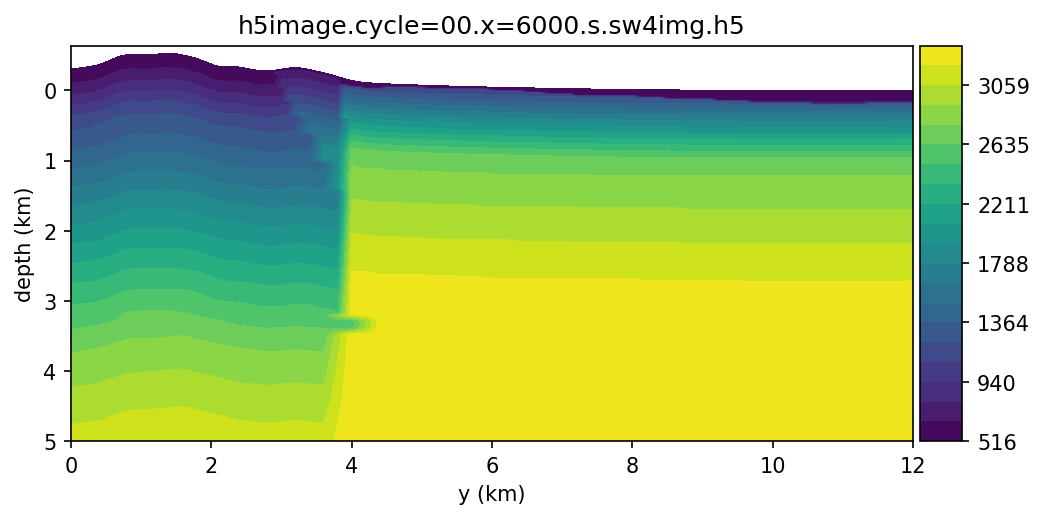

In [5]:
fname = '/global/cfs/cdirs/m3354/perl/sw4.debug/verify/berkeley/berkeley-att-h20-results/h5image.cycle=00.x=6000.s.sw4img.h5'
plotimageh5(fname)